In [1]:
#!python -m pip install pycodestyle_magic
#%load_ext pycodestyle_magic
#%pycodestyle_on

In [146]:
%pylab inline
import re
import pickle
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, precision_score, roc_curve, recall_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_roc_curve
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import manifold
from sklearn import cluster
from IPython.display import Image
from PIL import Image as Image_PIL
from PIL import Image as im
from scipy.ndimage import gaussian_filter
from scipy.stats import kurtosis, skew
import glob
import cv2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from functions import *
sns.set()

Populating the interactive namespace from numpy and matplotlib


/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['source', 'grid', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Main DataSet

#### Our train set will be our dataset that will be splited in train and data set for our modeling

In [3]:
data = pd.read_csv('application_train.csv')

### We see that we have an umbalenced model

In [4]:
data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

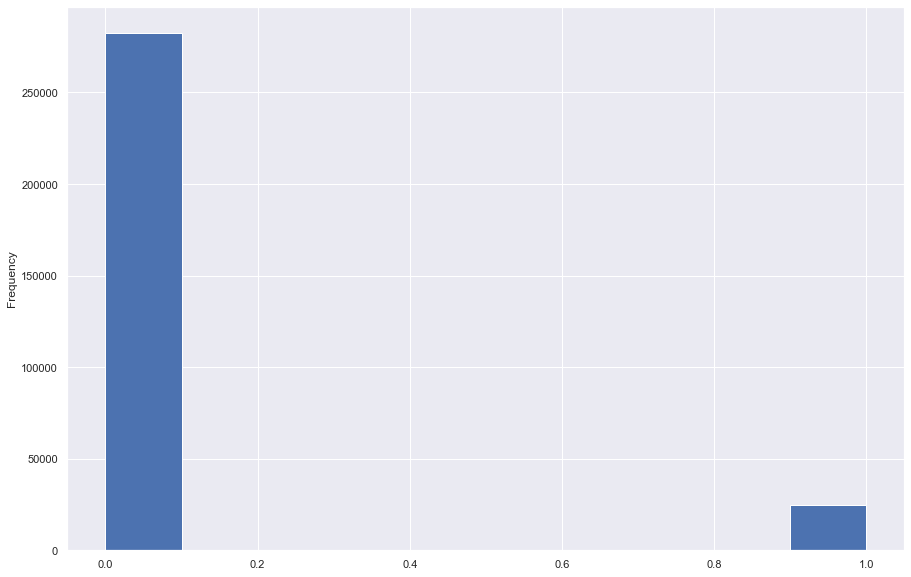

In [5]:
data['TARGET'].astype(int).plot.hist(figsize=(15,10));

### Looking for Missing Values

In [6]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
# Missing values statistics
missing_values = missing_values_table(data)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


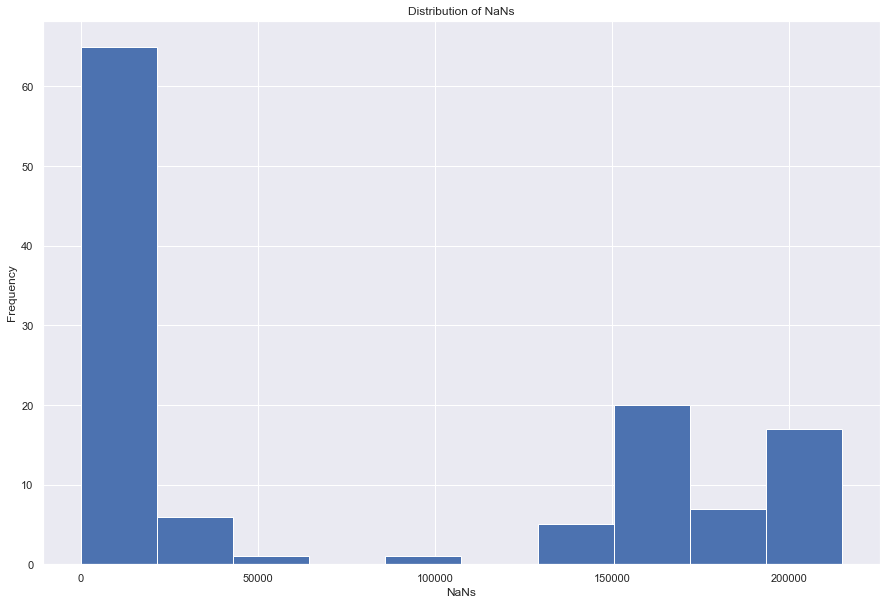

In [8]:
data.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')

plt.show()

### Data Types

In [9]:
data.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [10]:
data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### We take a look to the time variables 

In [11]:
data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [12]:
## We take a look to Days Birth
data['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [13]:
## We transform it to positive and to days
(data['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [14]:
## We take a look to employed days
data['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

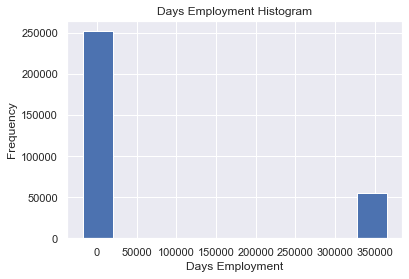

In [15]:
data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

#### This is not normal 365243 days is really big for and employment period so we can replace de day outliers with the following function:

In [16]:
def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

In [17]:
data=replace_day_outliers(data)

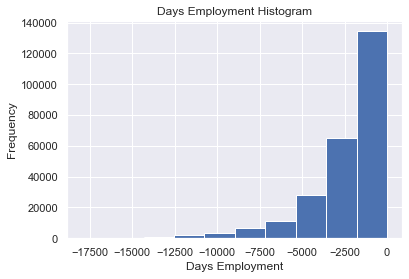

In [18]:
## We obtain a more logical day distribution (days employed before having the loan with HOME CREDIT)
data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

### Correlation with target: We are going to analyse some variables according to correlations to target results

In [19]:
# Find correlations with the target and sort
correlations = data.corr()['TARGET'].sort_values()

# Display correlatsions
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227


In [20]:
data['DAYS_BIRTH']

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307506    -9327
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: DAYS_BIRTH, Length: 307511, dtype: int64

In [21]:
# Find the correlation of the positive days since birth and target
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
data['DAYS_BIRTH'].corr(data['TARGET'])

-0.07823930830982712

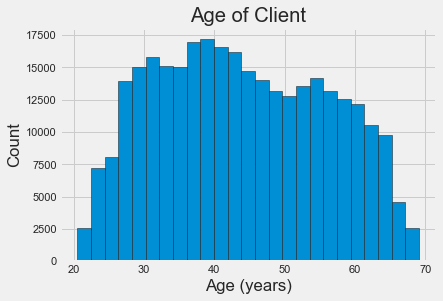

In [22]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(data['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

### KDE Plots

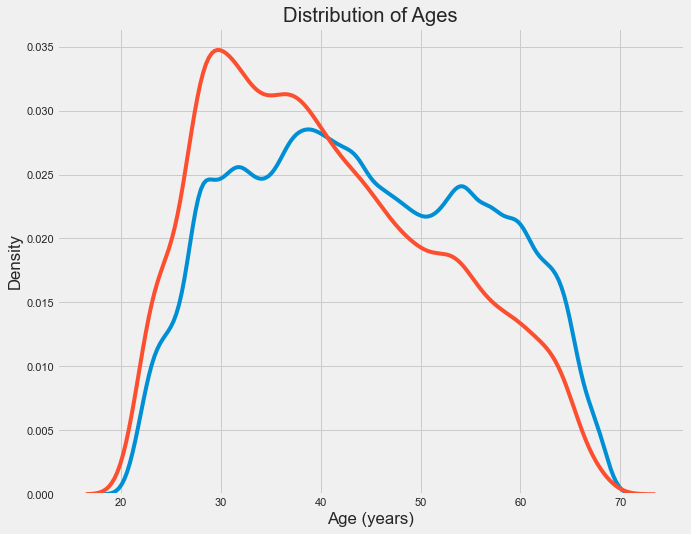

In [23]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [24]:
# Age information into a separate dataframe
age_data = data[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [25]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


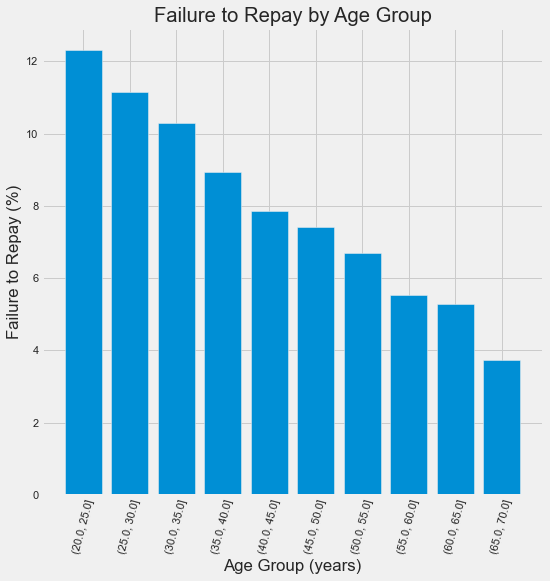

In [26]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### Exterior Sources

In [27]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = data[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


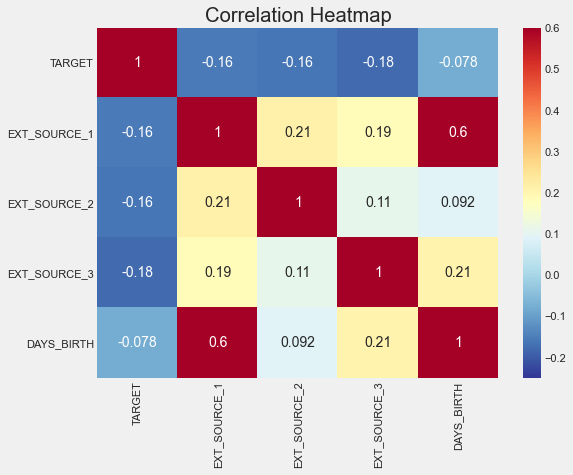

In [28]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

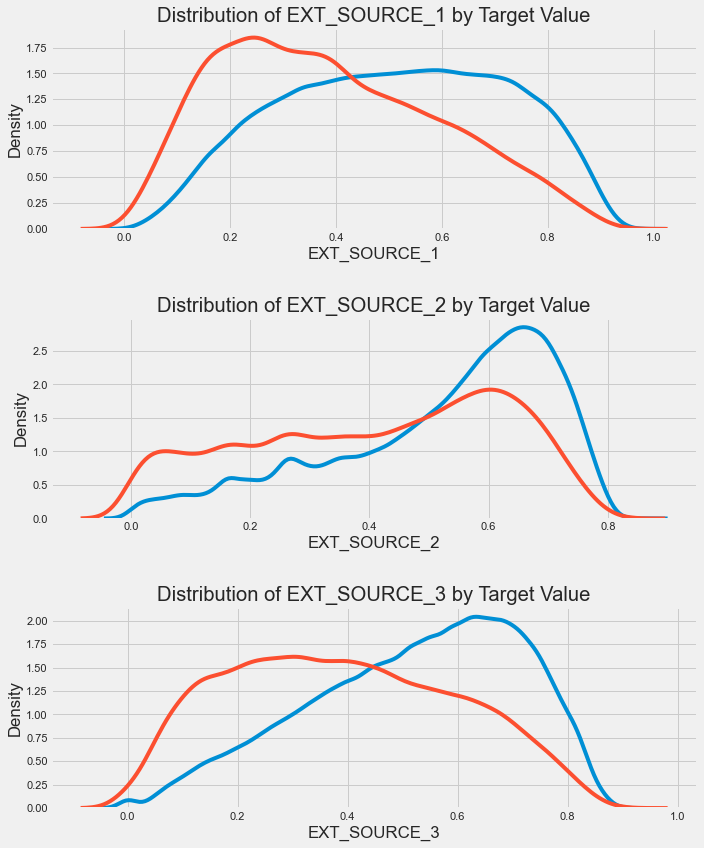

In [29]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(data.loc[data['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(data.loc[data['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/migueljosebern

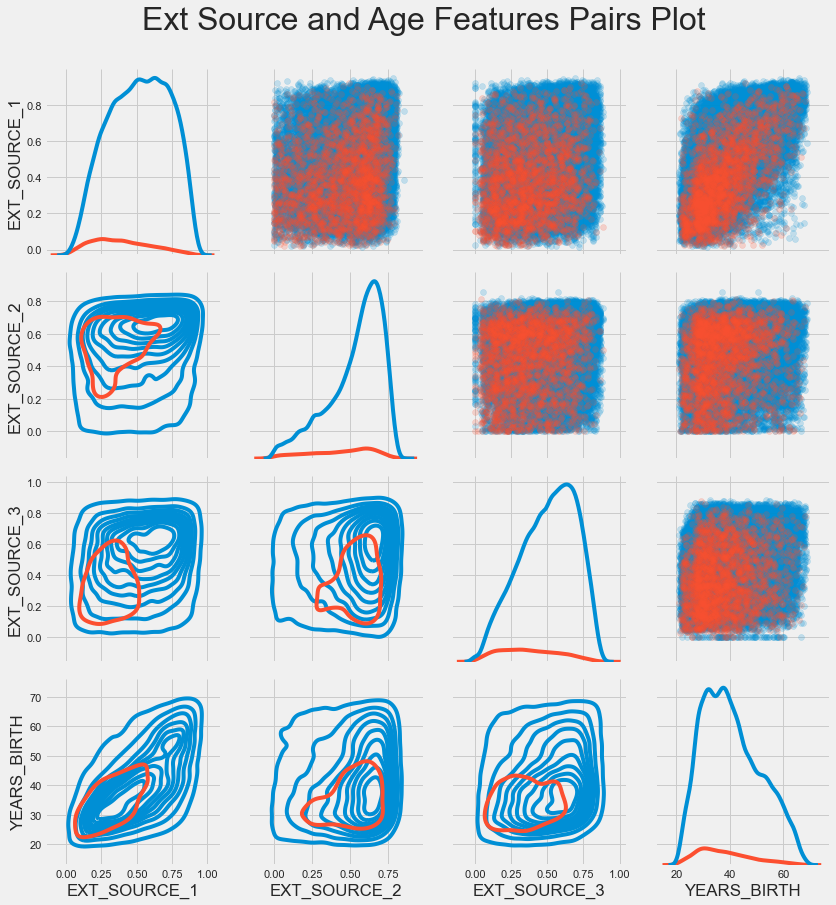

In [30]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

# Functions for other data Analysis  merge and Feature creation

## Numerical function: will create features for the statistical numerical variables (mean, min, max, sum) for any DataFrame

In [31]:
def agg_numeric(df, group_var, df_name):

    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

## Category Function: A dataframe with counts and normalized counts of each unique category in every categorical variable with one row for every unique value.

In [32]:
def count_categorical(df, group_var, df_name):
   
   # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

# Bureau file

In [33]:
bureau = pd.read_csv('bureau.csv')

In [34]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [35]:
## We apply the categorical variable transformation

bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### We calcule colinear correlations and we remove corrs above 0.8 for bureau counts

In [36]:
# Calculate all correlations in dataframe
corrs_bc = bureau_counts.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars_bc = {}

# For each column, record the variables that are above the threshold
for col in corrs_bc:
    above_threshold_vars_bc[col] = list(corrs_bc.index[corrs_bc[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars_bc.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  6


In [37]:
bureau_counts = bureau_counts.drop(columns = cols_to_remove)
bureau_counts.shape

(305811, 40)

In [189]:
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,...,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,1.0,0,...,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,1.0,0,...,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,1.0,0,...,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,1.0,0,...,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,1.0,0,...,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0


In [190]:
bureau_counts.to_csv('bureau_counts.csv')

In [38]:
## Numerical features for Bureau 

bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


## We calcule colinear correlations and we remove corrs above 0.8 for bureau "numerical"

In [39]:
# Calculate all correlations in dataframe
corrs_ba = bureau_agg.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars_ba = {}

# For each column, record the variables that are above the threshold
for col in corrs_ba:
    above_threshold_vars_ba[col] = list(corrs_ba.index[corrs_ba[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars_ba.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  23


In [40]:
bureau_agg = bureau_agg.drop(columns = cols_to_remove)
bureau_agg.shape

(305811, 38)

In [187]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_DAYS_CREDIT_ENDDATE_mean,...,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min
0,100001,7,-735.000000,-49,-1572,-5145,0.0,0,0,82.428571,...,0.0,0.0,0.0,-93.142857,-6,-155,7,3545.357143,10822.5,0.0
1,100002,8,-874.000000,-103,-1437,-6992,0.0,0,0,-349.000000,...,0.0,0.0,0.0,-499.875000,-7,-1185,7,0.000000,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,0.0,0,0,-544.500000,...,0.0,0.0,0.0,-816.000000,-43,-2131,0,NaN,NaN,NaN
3,100004,2,-867.000000,-408,-1326,-1734,0.0,0,0,-488.500000,...,0.0,0.0,0.0,-532.000000,-382,-682,0,NaN,NaN,NaN
4,100005,3,-190.666667,-62,-373,-572,0.0,0,0,439.333333,...,0.0,0.0,0.0,-54.333333,-11,-121,3,1420.500000,4261.5,0.0


In [188]:
bureau_agg.to_csv('bureau_agg.csv')

# Bureau Balance

In [41]:
bureau_balance = pd.read_csv('bureau_balance.csv')

In [42]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [43]:
## Category counts per loan

bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [44]:
## Numerical counts per loan

bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


### Numerical and Category counts of bureau balance per client

In [45]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

## We calcule colinear correlations and we remove corrs above 0.8 for bureau balance by client

In [46]:
# Calculate all correlations in dataframe
corrs_bbc = bureau_balance_by_client.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars_bbc = {}

# For each column, record the variables that are above the threshold
for col in corrs_bbc:
    above_threshold_vars_bbc[col] = list(corrs_bbc.index[corrs_bbc[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars_bbc.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  58


In [47]:
bureau_balance_by_client = bureau_balance_by_client.drop(columns = cols_to_remove)
bureau_balance_by_client.shape

(305811, 48)

In [185]:
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,...,client_bureau_balance_STATUS_5_count_min,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_norm_max,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min
0,100001,7,24.571429,2.0,-11.785714,-0.5,-25.5,-82.5,0.0,0.0,...,0.0,15.714286,0.0,0.966667,4.285714,9.0,0.0,0.214590,0.500000,0.0
1,100002,8,13.750000,4.0,-21.875000,-1.5,-39.5,-175.0,-15.5,0.0,...,0.0,2.875000,0.0,0.812500,1.875000,3.0,0.0,0.161932,0.500000,0.0
2,100003,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,3,7.000000,3.0,-3.000000,-1.0,-6.0,-9.0,0.0,0.0,...,0.0,1.666667,0.0,0.384615,0.666667,1.0,0.0,0.136752,0.333333,0.0


In [186]:
bureau_balance_by_client.to_csv('bureau_balance_by_client.csv')

# Previous applications file

In [48]:
previous = pd.read_csv('previous_application.csv')
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Numerical stats

previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
previous_agg.head()

/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,SK_ID_CURR,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_count,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_min,...,previous_DAYS_TERMINATION_count,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_sum,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.990,98356.995,6737.310,169661.970,3,435436.50,900000.0,68809.5,...,3,-1047.333333,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250,5357.250,5357.250,5357.250,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200,4813.200,4813.200,4813.200,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


## We calcule colinear correlations and we remove corrs above 0.8 for previous numerical stats

In [50]:
# Calculate all correlations in dataframe
corrs_pa = previous_agg.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars_pa = {}

# For each column, record the variables that are above the threshold
for col in corrs_pa:
    above_threshold_vars_pa[col] = list(corrs_pa.index[corrs_pa[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars_pa.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  58


In [51]:
previous_agg = previous_agg.drop(columns = cols_to_remove)
previous_agg.shape

(338857, 38)

In [191]:
previous_agg.head()

,SK_ID_CURR,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_min,previous_AMT_DOWN_PAYMENT_count,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_GOODS_PRICE_min,...,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_LAST_DUE_max,previous_DAYS_LAST_DUE_min,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000,3951.000,3951.000,24835.50,24835.5,1,2520.0,24835.5,...,-1709.000000,-1709.0,-1499.000000,-1499.0,-1619.000000,-1619.0,-1619.0,0.000000,0.0,0.0
1,100002,1,9251.775,9251.775,9251.775,179055.00,179055.0,1,0.0,179055.0,...,-565.000000,-565.0,125.000000,125.0,-25.000000,-25.0,-25.0,0.000000,0.0,0.0
2,100003,3,56553.990,6737.310,169661.970,435436.50,68809.5,2,3442.5,68809.5,...,-1274.333333,-2310.0,-1004.333333,-1980.0,-1054.333333,-536.0,-1980.0,0.666667,0.0,2.0
3,100004,1,5357.250,5357.250,5357.250,24282.00,24282.0,1,4860.0,24282.0,...,-784.000000,-784.0,-694.000000,-694.0,-724.000000,-724.0,-724.0,0.000000,0.0,0.0
4,100005,1,4813.200,4813.200,4813.200,22308.75,0.0,1,4464.0,44617.5,...,-706.000000,-706.0,-376.000000,-376.0,-466.000000,-466.0,-466.0,0.000000,0.0,0.0


In [192]:
previous_agg.to_csv('previous_agg.csv')

In [52]:
## Category stats

previous_counts = count_categorical(previous, 'SK_ID_CURR', 'previous')
previous_counts.head()

,previous_NAME_CONTRACT_TYPE_Cash loans_count,previous_NAME_CONTRACT_TYPE_Cash loans_count_norm,previous_NAME_CONTRACT_TYPE_Consumer loans_count,previous_NAME_CONTRACT_TYPE_Consumer loans_count_norm,previous_NAME_CONTRACT_TYPE_Revolving loans_count,previous_NAME_CONTRACT_TYPE_Revolving loans_count_norm,previous_NAME_CONTRACT_TYPE_XNA_count,previous_NAME_CONTRACT_TYPE_XNA_count_norm,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,...,previous_PRODUCT_COMBINATION_POS industry without interest_count,previous_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_PRODUCT_COMBINATION_POS mobile with interest_count,previous_PRODUCT_COMBINATION_POS mobile with interest_count_norm,previous_PRODUCT_COMBINATION_POS mobile without interest_count,previous_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_PRODUCT_COMBINATION_POS other with interest_count,previous_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_PRODUCT_COMBINATION_POS others without interest_count,previous_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.0,0,0.0,0,0.000000,...,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.0,0,0.0,1,0.333333,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
100005,1,0.500000,1,0.500000,0,0.0,0,0.0,1,0.500000,...,0,0.0,1,0.5,0,0.0,0,0.0,0,0.0


## We calcule colinear correlations and we remove corrs above 0.8 for previous category

In [53]:
# Calculate all correlations in dataframe
corrs_pc = previous_counts.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars_pc = {}

# For each column, record the variables that are above the threshold
for col in corrs_pc:
    above_threshold_vars_pc[col] = list(corrs_pc.index[corrs_pc[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars_pc.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  53


In [54]:
previous_counts = previous_counts.drop(columns = cols_to_remove)
previous_counts.shape

(338857, 233)

In [183]:
previous_counts.head()

,previous_NAME_CONTRACT_TYPE_Cash loans_count,previous_NAME_CONTRACT_TYPE_Cash loans_count_norm,previous_NAME_CONTRACT_TYPE_Consumer loans_count,previous_NAME_CONTRACT_TYPE_Consumer loans_count_norm,previous_NAME_CONTRACT_TYPE_Revolving loans_count,previous_NAME_CONTRACT_TYPE_Revolving loans_count_norm,previous_NAME_CONTRACT_TYPE_XNA_count,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,previous_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,previous_WEEKDAY_APPR_PROCESS_START_MONDAY_count,...,previous_PRODUCT_COMBINATION_POS industry with interest_count,previous_PRODUCT_COMBINATION_POS industry with interest_count_norm,previous_PRODUCT_COMBINATION_POS industry without interest_count,previous_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_PRODUCT_COMBINATION_POS mobile without interest_count,previous_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_PRODUCT_COMBINATION_POS other with interest_count,previous_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_PRODUCT_COMBINATION_POS others without interest_count,previous_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.0,0,1,1.000000,0,...,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.0,0,0,0.000000,0,...,0,0.000000,0,0.0,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.0,0,1,0.333333,0,...,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,1,1.000000,0,0.0,0,1,1.000000,0,...,0,0.000000,0,0.0,1,1.0,0,0.0,0,0.0
100005,1,0.500000,1,0.500000,0,0.0,0,1,0.500000,0,...,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0


In [184]:
previous_counts.to_csv('previous_counts.csv')

### To add the other data tables we use a new function that groups several loan variables to calculate category and  numerical stats (as the other two previous functions) and then it develops the stats by client.

In [55]:
def aggregate_client(df, group_vars, df_names):
    
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = count_categorical(df, group_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
   

    return df_by_client

### Monthly Cash Data

In [56]:
## cash by loan
cash = pd.read_csv('POS_CASH_balance.csv')
cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [57]:
## We use our aggregate client function

cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,SK_ID_CURR,client_cash_MONTHS_BALANCE_count_count,client_cash_MONTHS_BALANCE_count_mean,client_cash_MONTHS_BALANCE_count_max,client_cash_MONTHS_BALANCE_count_min,client_cash_MONTHS_BALANCE_count_sum,client_cash_MONTHS_BALANCE_mean_count,client_cash_MONTHS_BALANCE_mean_mean,client_cash_MONTHS_BALANCE_mean_max,client_cash_MONTHS_BALANCE_mean_min,...,client_cash_SK_DPD_DEF_min_count,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_min,client_cash_SK_DPD_DEF_min_sum,client_cash_SK_DPD_DEF_sum_count,client_cash_SK_DPD_DEF_sum_mean,client_cash_SK_DPD_DEF_sum_max,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_DEF_sum_sum
0,100001,9,4.555556,5,4,41,9,-72.555556,-55.0,-94.5,...,9,0.0,0,0,0,9,3.111111,7,0,28
1,100002,19,19.000000,19,19,361,19,-10.000000,-10.0,-10.0,...,19,0.0,0,0,0,19,0.000000,0,0,0
2,100003,28,9.714286,12,8,272,28,-43.785714,-21.5,-71.5,...,28,0.0,0,0,0,28,0.000000,0,0,0
3,100004,4,4.000000,4,4,16,4,-25.500000,-25.5,-25.5,...,4,0.0,0,0,0,4,0.000000,0,0,0
4,100005,11,11.000000,11,11,121,11,-20.000000,-20.0,-20.0,...,11,0.0,0,0,0,11,0.000000,0,0,0


## We calcule colinear correlations and we remove corrs above 0.8 for cash by client

In [58]:
# Calculate all correlations in dataframe
corrs_cc = cash_by_client.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars_cc = {}

# For each column, record the variables that are above the threshold
for col in corrs_cc:
    above_threshold_vars_cc[col] = list(corrs_cc.index[corrs_cc[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars_cc.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  105


In [59]:
cash_by_client = cash_by_client.drop(columns = cols_to_remove)
cash_by_client.shape

(337252, 21)

In [181]:
cash_by_client.head()

,SK_ID_CURR,client_cash_MONTHS_BALANCE_count_count,client_cash_MONTHS_BALANCE_count_mean,client_cash_MONTHS_BALANCE_count_min,client_cash_MONTHS_BALANCE_mean_mean,client_cash_MONTHS_BALANCE_mean_max,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_CNT_INSTALMENT_mean_mean,...,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_cash_CNT_INSTALMENT_FUTURE_min_min,client_cash_SK_DPD_mean_mean,client_cash_SK_DPD_mean_min,client_cash_SK_DPD_min_mean,client_cash_SK_DPD_min_min,client_cash_SK_DPD_DEF_mean_mean,client_cash_SK_DPD_DEF_mean_min,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_min
0,100001,9,4.555556,4,-72.555556,-55.0,-653.0,-320.777778,-275,4.000000,...,0.000000,0.0,0.777778,0.0,0.0,0,0.777778,0.0,0.0,0
1,100002,19,19.000000,19,-10.000000,-10.0,-190.0,-190.000000,-190,24.000000,...,6.000000,6.0,0.000000,0.0,0.0,0,0.000000,0.0,0.0,0
2,100003,28,9.714286,8,-43.785714,-21.5,-1226.0,-472.857143,-172,10.107143,...,0.428571,0.0,0.000000,0.0,0.0,0,0.000000,0.0,0.0,0
3,100004,4,4.000000,4,-25.500000,-25.5,-102.0,-102.000000,-102,3.750000,...,0.000000,0.0,0.000000,0.0,0.0,0,0.000000,0.0,0.0,0
4,100005,11,11.000000,11,-20.000000,-20.0,-220.0,-220.000000,-220,11.700000,...,0.000000,0.0,0.000000,0.0,0.0,0,0.000000,0.0,0.0,0


In [182]:
cash_by_client.to_csv('cash_by_client.csv')

### Credit Data File

In [60]:
credit = pd.read_csv('credit_card_balance.csv')
credit.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [173]:
## We use our aggregate client function

credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client

/Users/migueljosebernalmora/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,SK_ID_CURR,client_credit_MONTHS_BALANCE_count_count,client_credit_MONTHS_BALANCE_count_mean,client_credit_MONTHS_BALANCE_count_max,client_credit_MONTHS_BALANCE_count_min,client_credit_MONTHS_BALANCE_count_sum,client_credit_MONTHS_BALANCE_mean_count,client_credit_MONTHS_BALANCE_mean_mean,client_credit_MONTHS_BALANCE_mean_max,client_credit_MONTHS_BALANCE_mean_min,...,client_credit_SK_DPD_DEF_min_count,client_credit_SK_DPD_DEF_min_mean,client_credit_SK_DPD_DEF_min_max,client_credit_SK_DPD_DEF_min_min,client_credit_SK_DPD_DEF_min_sum,client_credit_SK_DPD_DEF_sum_count,client_credit_SK_DPD_DEF_sum_mean,client_credit_SK_DPD_DEF_sum_max,client_credit_SK_DPD_DEF_sum_min,client_credit_SK_DPD_DEF_sum_sum
0,100006,6,6.0,6,6,36,6,-3.5,-3.5,-3.5,...,6,0,0,0,0,6,0.0,0,0,0
1,100011,74,74.0,74,74,5476,74,-38.5,-38.5,-38.5,...,74,0,0,0,0,74,0.0,0,0,0
2,100013,96,96.0,96,96,9216,96,-48.5,-48.5,-48.5,...,96,0,0,0,0,96,1.0,1,1,96
3,100021,17,17.0,17,17,289,17,-10.0,-10.0,-10.0,...,17,0,0,0,0,17,0.0,0,0,0
4,100023,8,8.0,8,8,64,8,-7.5,-7.5,-7.5,...,8,0,0,0,0,8,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,41,41.0,41,41,1681,41,-21.0,-21.0,-21.0,...,41,0,0,0,0,41,0.0,0,0,0
103554,456246,8,8.0,8,8,64,8,-5.5,-5.5,-5.5,...,8,0,0,0,0,8,0.0,0,0,0
103555,456247,95,95.0,95,95,9025,95,-49.0,-49.0,-49.0,...,95,0,0,0,0,95,2.0,2,2,190
103556,456248,23,23.0,23,23,529,23,-13.0,-13.0,-13.0,...,23,0,0,0,0,23,0.0,0,0,0


## We calcule colinear correlations and we remove corrs above 0.8 for credit by client

In [177]:
# Calculate all correlations in dataframe
corrs_crc = credit_by_client.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars_crc = {}

# For each column, record the variables that are above the threshold
for col in corrs_crc:
    above_threshold_vars_crc[col] = list(corrs_crc.index[corrs_crc[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars_crc.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  445


In [178]:
credit_by_client = credit_by_client.drop(columns = cols_to_remove)
credit_by_client.shape

(103558, 56)

In [179]:
credit_by_client.head()

,SK_ID_CURR,client_credit_MONTHS_BALANCE_count_count,client_credit_MONTHS_BALANCE_mean_mean,client_credit_MONTHS_BALANCE_max_mean,client_credit_AMT_BALANCE_mean_mean,client_credit_AMT_BALANCE_mean_sum,client_credit_AMT_BALANCE_min_mean,client_credit_AMT_BALANCE_min_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_sum,...,client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_mean,client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_sum,client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_max_sum,client_credit_CNT_DRAWINGS_POS_CURRENT_min_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_CNT_INSTALMENT_MATURE_CUM_min_mean,client_credit_SK_DPD_mean_mean,client_credit_SK_DPD_min_mean,client_credit_SK_DPD_DEF_mean_mean
0,100006,6,-3.5,-1,0.000000,0.000,0.0,0.0,270000.000000,1620000.0,...,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.000000,0,0.000000
1,100011,74,-38.5,-2,54482.111149,4031676.225,0.0,0.0,164189.189189,12150000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0,0.000000
2,100013,96,-48.5,-1,18159.919219,1743352.245,0.0,0.0,131718.750000,12645000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.010417,0,0.010417
3,100021,17,-10.0,-2,0.000000,0.000,0.0,0.0,675000.000000,11475000.0,...,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.000000,0,0.000000
4,100023,8,-7.5,-4,0.000000,0.000,0.0,0.0,135000.000000,1080000.0,...,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.000000,0,0.000000


In [180]:
credit_by_client.to_csv('credit_by_client.csv')

### Payment Installements File

In [64]:
installments = pd.read_csv('installments_payments.csv')
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [65]:
## We use our aggregate client function

installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,SK_ID_CURR,client_installments_NUM_INSTALMENT_VERSION_count_count,client_installments_NUM_INSTALMENT_VERSION_count_mean,client_installments_NUM_INSTALMENT_VERSION_count_max,client_installments_NUM_INSTALMENT_VERSION_count_min,client_installments_NUM_INSTALMENT_VERSION_count_sum,client_installments_NUM_INSTALMENT_VERSION_mean_count,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
0,100001,7,3.571429,4,3,25,7,1.142857,1.250000,1.000000,...,7,3963.8250,3980.925,3951.000,27746.775,7,21834.096429,29250.900,11945.025,1.528387e+05
1,100002,19,19.000000,19,19,361,19,1.052632,1.052632,1.052632,...,19,9251.7750,9251.775,9251.775,175783.725,19,219625.695000,219625.695,219625.695,4.172888e+06
2,100003,25,9.160000,12,6,229,25,1.040000,1.142857,1.000000,...,25,46164.3318,98356.995,6662.970,1154108.295,25,453952.220400,1150977.330,80773.380,1.134881e+07
3,100004,3,3.000000,3,3,9,3,1.333333,1.333333,1.333333,...,3,5357.2500,5357.250,5357.250,16071.750,3,21288.465000,21288.465,21288.465,6.386540e+04
4,100005,9,9.000000,9,9,81,9,1.111111,1.111111,1.111111,...,9,4813.2000,4813.200,4813.200,43318.800,9,56161.845000,56161.845,56161.845,5.054566e+05


## We calcule colinear correlations and we remove corrs above 0.8 for installements by client

In [66]:
# Calculate all correlations in dataframe
corrs_ic = installments_by_client.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars_ic = {}

# For each column, record the variables that are above the threshold
for col in corrs_ic:
    above_threshold_vars_ic[col] = list(corrs_ic.index[corrs_ic[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars_ic.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  118


In [67]:
installments_by_client = installments_by_client.drop(columns = cols_to_remove)
installments_by_client.head()

(339587, 33)

In [174]:
installments_by_client.head()

,SK_ID_CURR,client_installments_NUM_INSTALMENT_VERSION_count_count,client_installments_NUM_INSTALMENT_VERSION_count_mean,client_installments_NUM_INSTALMENT_VERSION_count_min,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,client_installments_NUM_INSTALMENT_VERSION_mean_sum,client_installments_NUM_INSTALMENT_VERSION_min_mean,client_installments_NUM_INSTALMENT_VERSION_min_max,...,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_mean,client_installments_AMT_INSTALMENT_max_max,client_installments_AMT_INSTALMENT_max_min,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_INSTALMENT_min_mean,client_installments_AMT_INSTALMENT_sum_mean,client_installments_AMT_INSTALMENT_sum_min,client_installments_AMT_INSTALMENT_sum_sum,client_installments_AMT_PAYMENT_min_sum
0,100001,7,3.571429,3,1.142857,1.250000,1.000000,8.0,1.0,1.0,...,41195.925,11648.2500,17397.900,3982.050,81537.750,3963.8250,21834.096429,11945.025,1.528387e+05,27746.775
1,100002,19,19.000000,19,1.052632,1.052632,1.052632,20.0,1.0,1.0,...,219625.695,53093.7450,53093.745,53093.745,1008781.155,9251.7750,219625.695000,219625.695,4.172888e+06,175783.725
2,100003,25,9.160000,6,1.040000,1.142857,1.000000,26.0,1.0,1.0,...,1618864.650,175764.0492,560835.360,6737.310,4394101.230,46164.3318,453952.220400,80773.380,1.134881e+07,1154108.295
3,100004,3,3.000000,3,1.333333,1.333333,1.333333,4.0,1.0,1.0,...,21288.465,10573.9650,10573.965,10573.965,31721.895,5357.2500,21288.465000,21288.465,6.386540e+04,16071.750
4,100005,9,9.000000,9,1.111111,1.111111,1.111111,10.0,1.0,1.0,...,56161.845,17656.2450,17656.245,17656.245,158906.205,4813.2000,56161.845000,56161.845,5.054566e+05,43318.800


In [175]:
installments_by_client.to_csv('installments_by_client.csv')

# We join all our data together

In [68]:
# Merge with the value counts of bureau
data = data.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
data = data.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
data = data.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of previous applications
data = data.merge(previous_counts, on ='SK_ID_CURR', how = 'left')

# Merge with the stats of previous applications
data = data.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Merge cash by client
data = data.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

# Merge credit by client
data = data.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

# Merge installements by client
data = data.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

In [69]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_mean,client_installments_AMT_INSTALMENT_max_max,client_installments_AMT_INSTALMENT_max_min,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_INSTALMENT_min_mean,client_installments_AMT_INSTALMENT_sum_mean,client_installments_AMT_INSTALMENT_sum_min,client_installments_AMT_INSTALMENT_sum_sum,client_installments_AMT_PAYMENT_min_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,219625.695,53093.745000,53093.745,53093.745,1008781.155,9251.775000,219625.695000,219625.695,4.172888e+06,175783.725
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1618864.650,175764.049200,560835.360,6737.310,4394101.230,46164.331800,453952.220400,80773.380,1.134881e+07,1154108.295
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,21288.465,10573.965000,10573.965,10573.965,31721.895,5357.250000,21288.465000,21288.465,6.386540e+04,16071.750
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,1007153.415,66116.269688,691786.890,15159.645,1057860.315,62154.793125,232499.719688,25091.325,3.719996e+06,994476.690
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,835985.340,12677.324318,22678.785,1834.290,836703.405,12512.815909,178659.664091,18330.390,1.179154e+07,483756.390


In [70]:
data.shape

(307511, 623)

### Missed Values for the gathered Dataset

In [71]:
# Missing values statistics
missing_values = missing_values_table(data)
missing_values.head(20)

Your selected dataframe has 623 columns.
There are 569 columns that have missing values.


,Missing Values,% of Total Values
previous_RATE_INTEREST_PRIMARY_mean,302902,98.5
previous_RATE_INTEREST_PRIVILEGED_mean,302902,98.5
client_credit_AMT_PAYMENT_CURRENT_max_mean,246451,80.1
client_credit_AMT_PAYMENT_CURRENT_min_mean,246451,80.1
client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_mean,246371,80.1
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean,246371,80.1
client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_mean,246371,80.1
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean,246371,80.1
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean,246371,80.1
client_credit_AMT_DRAWINGS_POS_CURRENT_max_mean,246371,80.1


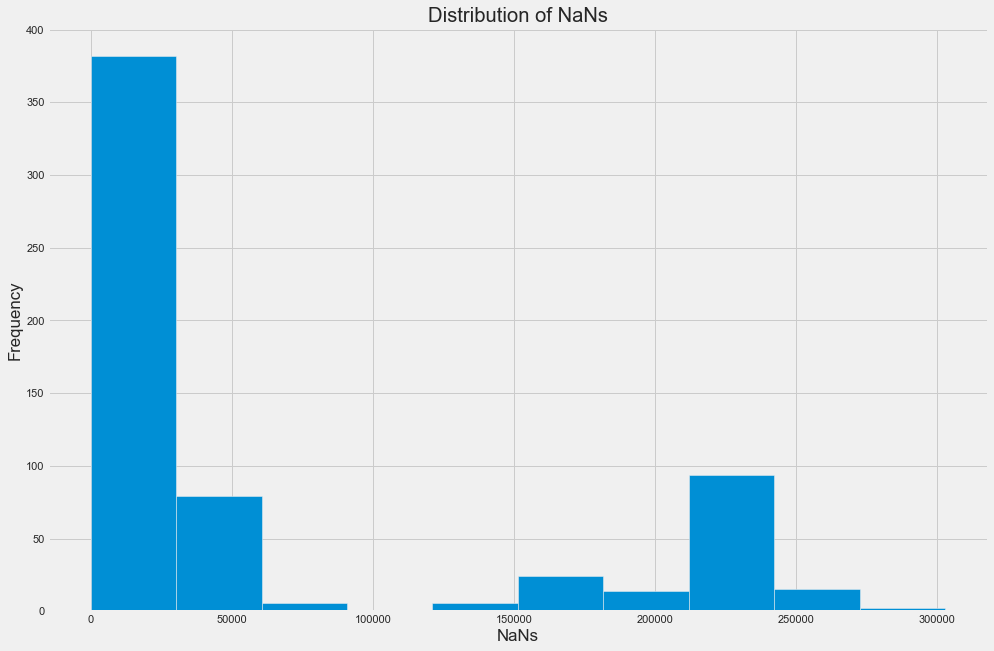

In [72]:
data.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')

plt.show()

##  We remove missing values

In [73]:
def remove_missing_columns(data, threshold = 75):
    # Calculate missing stats (remember to calculate a percent!)
    data_miss = pd.DataFrame(data.isnull().sum())
    data_miss['percent'] = 100 * data_miss[0] / len(data)
    
    
    # list of missing columns for data
    missing_data_columns = list(data_miss.index[data_miss['percent'] > threshold])
    
    
    #lists of missed columns
    missing_columns = list(set(missing_data_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    data = data.drop(columns = missing_columns)
    
    
    return data

In [74]:
data = remove_missing_columns(data)

There are 17 columns with greater than 75% missing values.


In [75]:
data.shape

(307511, 606)

### Column types

In [76]:
# Number of each type of column
data.dtypes.value_counts()

float64    550
int64       40
object      16
dtype: int64

In [77]:
export_columns = data.select_dtypes('object').columns.union(['SK_ID_CURR','DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'])

In [78]:
data[export_columns].to_csv('data_dashboard.csv')

In [79]:
data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### We apply our encoding by using label encoding with features with less than 2 variables and one hot encoding for the others

In [80]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the data
            le.fit(data[col])
            # Transform data
            data[col] = le.transform(data[col])
            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [81]:
data = pd.get_dummies(data)
print('Data Features shape: ', data.shape)

Data Features shape:  (307511, 727)


### We recall that we still have an imbalanced classification model 

In [82]:
data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

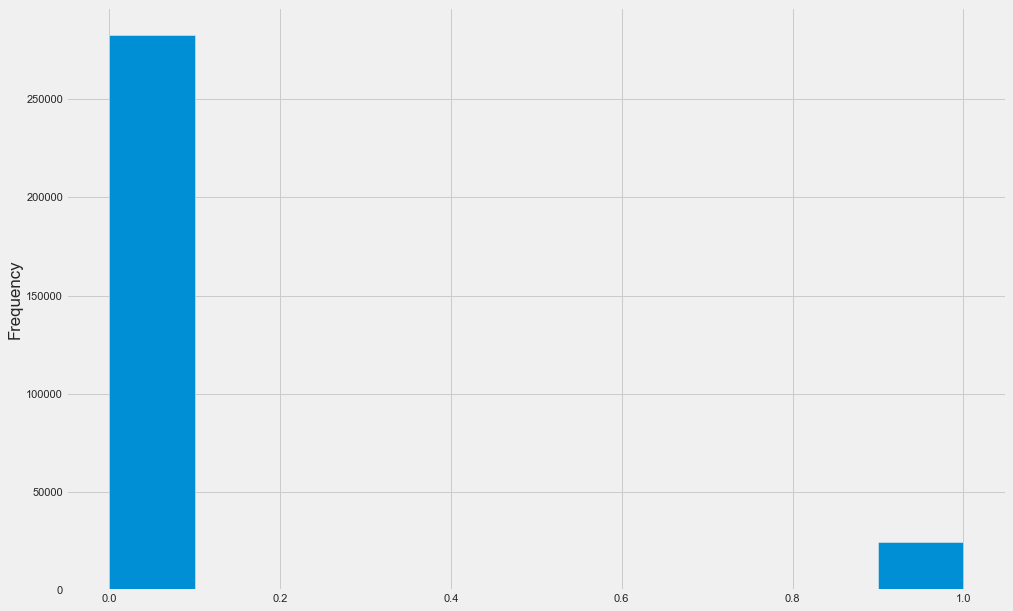

In [83]:
data['TARGET'].astype(int).plot.hist(figsize=(15,10));

# MODELING

## We assign our model and target

In [84]:
# We store our clients ids
id_clients=data['SK_ID_CURR']

In [85]:
id_clients

0         100002
1         100003
2         100004
3         100006
4         100007
           ...  
307506    456251
307507    456252
307508    456253
307509    456254
307510    456255
Name: SK_ID_CURR, Length: 307511, dtype: int64

In [86]:
data_model = data.drop(columns = ['TARGET'])
target = data['TARGET']   

In [87]:
data_model.shape

(307511, 726)

In [88]:
target.shape

(307511,)

In [89]:
# Feature names
features = list(data_model.columns)

In [90]:
# Median imputation of missing values
imputer = SimpleImputer(strategy='median')

In [91]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

In [92]:
# Fit on the model data
imputer.fit(data_model)

SimpleImputer(strategy='median')

In [93]:
# Transform model data
data_model = imputer.transform(data_model)

In [94]:
# Repeat with the scaler
scaler.fit(data_model)
data_model = scaler.transform(data_model)

In [95]:
pd.DataFrame(data_model).head()

,0,1,2,3,4,5,6,7,8,9,...,716,717,718,719,720,721,722,723,724,725
0,0.000000,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.000003,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000006,1.0,1.0,1.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000011,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000014,0.0,0.0,1.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## We apply PCA for variable reduction

In [96]:
pca = PCA()
pca.fit(data_model)

PCA()

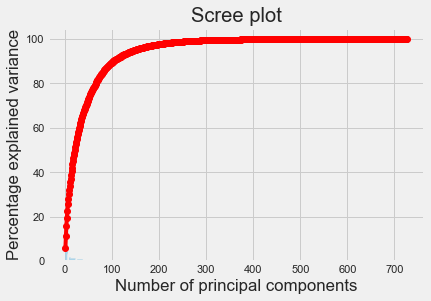

In [97]:
display_scree_plot(pca)

In [98]:
pca.explained_variance_ratio_.cumsum()[100]

0.8974539332321684

In [99]:
pca = PCA(n_components=100)
pca.fit(data_model)
data_model_reduced = pca.transform(data_model)

In [100]:
data_model_reduced

array([[-6.70789389e-01,  1.13235139e+00,  3.09137465e-02, ...,
         2.95982338e-01,  2.39515979e-01,  3.89449416e-01],
       [ 4.10653722e-01,  1.11513687e+00,  3.18794311e-01, ...,
        -2.52494813e-01, -1.21219680e-01, -7.50365665e-02],
       [-1.40809881e+00, -2.09748037e-01,  7.95969972e-01, ...,
        -6.28395299e-02, -4.46147958e-02, -1.24653319e-01],
       ...,
       [-3.95853286e-01,  1.24674553e+00,  3.45101812e-01, ...,
         2.04623047e-01, -2.33478313e-01, -7.16055063e-02],
       [-2.39040107e-01,  3.89690679e-01,  3.31333133e-01, ...,
        -1.43861924e-01, -2.48754736e-02, -7.18527012e-04],
       [-1.00100610e-01,  9.47438169e-01, -7.57093561e-01, ...,
         1.50448034e-01, -1.72186149e-01, -1.15305013e-01]])

## Exporting Reduced Data Matrix for our dashboard application

In [101]:
pd.DataFrame(data_model_reduced, index=id_clients.values).to_csv('data_model_red.csv', index_label='index')

In [102]:
data_ = pd.read_csv('data_model_red.csv', index_col='index')

In [103]:
## Testing data client # 100003 for api code importation

x_=data_.loc[100003].values.reshape(1, -1)

## Including clients id before splitting

In [104]:
data_model_reduced_split=pd.DataFrame(data_model_reduced)

In [105]:
data_model_reduced_split['SK_ID_CURR']= id_clients

### We split our model

In [106]:
X_train, X_test, y_train, y_test = train_test_split(data_model_reduced_split, target, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (215257, 101)
Number transactions y_train dataset:  (215257,)
Number transactions X_test dataset:  (92254, 101)
Number transactions y_test dataset:  (92254,)


In [107]:
id_test= X_test['SK_ID_CURR']
id_train = X_train['SK_ID_CURR']

In [108]:
X_test = X_test.drop(columns = ['SK_ID_CURR'])
X_train = X_train.drop(columns = ['SK_ID_CURR'])

## We are going to apply smoteenn which combines oversampling and undersampling

In [109]:
#print("Before smoteenn, counts of label '1': {}".format(sum(y_train==1)))
#print("Before smoteenn, counts of label '0': {} \n".format(sum(y_train==0)))

#sm = SMOTE(kind='svm')
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#print('After smoteenn, the shape of train_X: {}'.format(X_train_res.shape))
#print('After smoteenn, the shape of train_y: {} \n'.format(y_train_res.shape))

#print("After smoteenn, counts of label '1': {}".format(sum(y_train_res==1)))
#print("After smoteenn, counts of label '0': {}".format(sum(y_train_res==0)))

## Function Cost

In [110]:
from sklearn.metrics import make_scorer
def cost(truth, preds):
    precision = precision_score(truth, preds, zero_division=1)
    recall = recall_score(truth, preds)
    # square beta
    beta2 = 2.5**2
    f_mesure = ((1+beta2)*precision*recall)/(beta2*(precision+recall))
    return f_mesure

custom_scorer = make_scorer(cost, greater_is_better=False)


## Regression Logistic

In [156]:
# Logistic Regression/ looking for regularization parameters 

parameters = {
    'C': np.linspace(0, 1, 10)
           }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3, scoring=custom_scorer)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   13.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   42.5s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             scoring=make_scorer(cost, greater_is_better=False), verbose=5)

In [157]:
clf.best_params_

{'C': 0.1111111111111111}

In [158]:
# Make predictions
# Make sure to select the second column only
pred_lr = clf.predict_proba(X_test)[:, 1]

In [159]:
pred_lr

array([0.25915051, 0.069791  , 0.04006236, ..., 0.04698689, 0.03851984,
       0.03337134])

In [160]:
# Results for X tests (Regression Logistic), probability of non paying the loan

results_lr = pd.DataFrame(id_test)

results_lr['TARGET'] = pred_lr

results_lr

,SK_ID_CURR,TARGET
42962,149741,0.259151
227307,363290,0.069791
290035,436006,0.040062
239833,377703,0.080450
76427,188624,0.189557
...,...,...
254862,394911,0.043214
127339,247674,0.031752
293474,440001,0.046987
10585,112330,0.038520


In [161]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 1.2925364598227052%


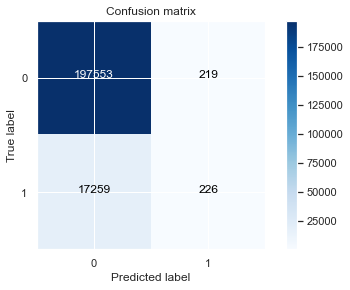

In [162]:
y_train_pre = clf.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 1.1580381471389645%


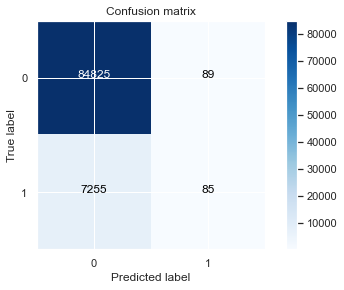

In [163]:
y_pre = clf.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [164]:
tmp = clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   11.6s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   45.8s finished


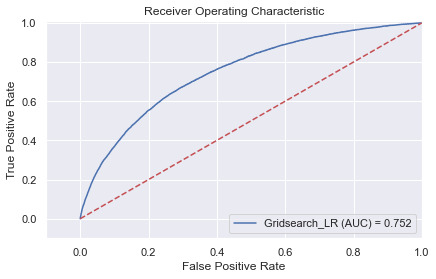

In [165]:
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
ax = plt.gca()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Gridsearch_LR (AUC) = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## RandomForest

In [121]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

In [122]:
param_grid={'n_estimators':[10,100,200],'max_depth':[2,10]}

In [123]:
from sklearn import model_selection

CV_rfc=model_selection.GridSearchCV(estimator=random_forest,param_grid=param_grid,cv=5,scoring=custom_scorer)

In [124]:
# Train on data_reduced

CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 10], 'n_estimators': [10, 100, 200]},
             scoring=make_scorer(cost, greater_is_better=False))

In [125]:
# Feature names
features = list(pd.DataFrame(data_model_reduced).columns)

In [126]:
CV_rfc.best_params_

{'max_depth': 2, 'n_estimators': 10}

In [127]:
random_forest = RandomForestClassifier(n_estimators=10, max_depth=2)

In [128]:
random_forest.fit(X_train, y_train)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})



In [129]:
# Make predictions on the test data
predictions = CV_rfc.predict_proba(X_test)[:, 1]

In [130]:
## Results for X_test (Random Forest), probability of non paying the loan.

results_rf = pd.DataFrame(id_test)

results_rf['TARGET'] = predictions

results_rf

,SK_ID_CURR,TARGET
42962,149741,0.105472
227307,363290,0.078783
290035,436006,0.065291
239833,377703,0.079393
76427,188624,0.079742
...,...,...
254862,394911,0.066933
127339,247674,0.076626
293474,440001,0.091817
10585,112330,0.081491


Recall metric in the train dataset: 0.0%


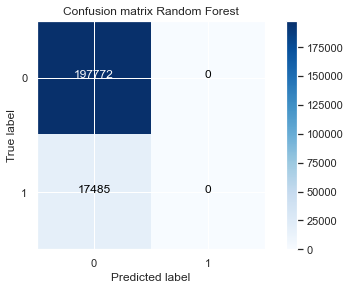

In [166]:
y_train_pre_rf = CV_rfc.predict(X_train)

cnf_matrix_tra_rf = confusion_matrix(y_train, y_train_pre_rf)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra_rf[1,1]/(cnf_matrix_tra_rf[1,0]+cnf_matrix_tra_rf[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra_rf , classes=class_names, title='Confusion matrix Random Forest')
plt.show()

Recall metric in the testing dataset: 0.0%


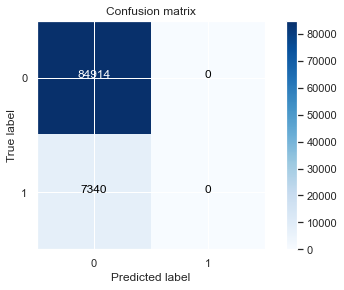

In [167]:
y_pre_rf = CV_rfc.predict(X_test)

cnf_matrix_rf = confusion_matrix(y_test, y_pre_rf)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix_rf[1,1]/(cnf_matrix_rf[1,0]+cnf_matrix_rf[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rf , classes=class_names, title='Confusion matrix')
plt.show()

In [143]:
tmp_rf=CV_rfc.fit(X_train, y_train)

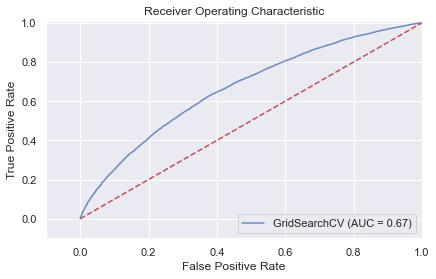

In [168]:
## Random Forest ROC PLOT

ax = plt.gca()
rfc_disp = plot_roc_curve(CV_rfc, X_test, y_test, ax=ax, alpha=0.8)

## ROC PLOT
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Graph Random Forest vs  Logistic Regression

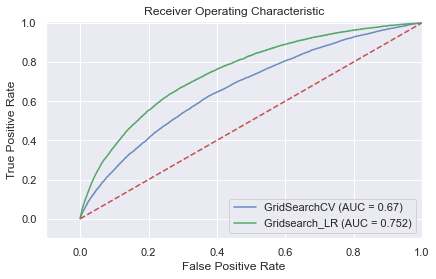

In [172]:
ax = plt.gca()
rfc_disp = plot_roc_curve(CV_rfc, X_test, y_test, ax=ax, alpha=0.8)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'g',label='GridsearchCV_LR (AUC = %0.3f)'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Features Importances

In [132]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances PCA')
    plt.show()
    
    return df

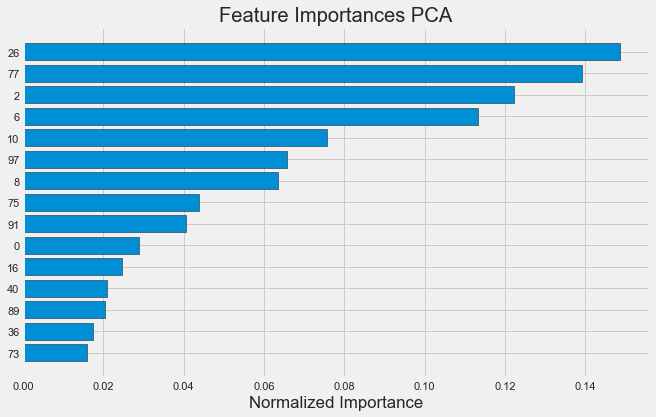

In [133]:
# Show the feature importances for the PC's of our reduced Matrix 

feature_importances_sorted = plot_feature_importances(feature_importances)

## Saving Models Using Pickle 

In [134]:
## Exporting Regression Logistic 

filename = 'model_lr.sav'
pickle.dump(clf, open(filename, 'wb'))

In [135]:
## Testing model for api code (client # 100003), class prediction value

clf.predict(x_)[0]

0

In [136]:
## Testing model (client # 100003) for api code, probability of paying value

clf.predict_proba(x_)[0][0]

0.9911878101482234

In [137]:
## Random Forest

filename2 = 'model_rf.sav'
pickle.dump(CV_rfc, open(filename2, 'wb'))


In [138]:
## Testing model for api code (client # 100003), class prediction value

CV_rfc.predict(x_)[0]

0

In [139]:
## Testing model (client # 100003) for api code, probability of paying value

CV_rfc.predict_proba(x_)[0][0]

0.9277458158727979